# Homework week 2

The purpose of this notebook is to do the Statistical Rethinking 2022 [homework](https://github.com/rmcelreath/stat_rethinking_2022/tree/main/homework) using Python.

In [1]:
import arviz as az
import daft
from causalgraphicalmodels import CausalGraphicalModel
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns

In [2]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

<IPython.core.display.Javascript object>

In [3]:
def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

In [4]:
DATA_DIR = '/Users/blacar/Documents/ds_projects/stats_rethinking/pymc3_ed_resources/resources/Rethinking/Data/'
df_howell = pd.read_csv(DATA_DIR + "Howell1.csv", sep=";", header=0)
df_howell.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


<IPython.core.display.Javascript object>

# Q1

Construct a linear regression of weight as predicted by height, using the
adults (age 18 or greater) from the Howell1 dataset. The heights listed below
were recorded in the !Kung census, but weights were not recorded for these
individuals. Provide predicted weights and 89% compatibility intervals for
each of these individuals. That is, fill in the table below, using model-based
predictions.

| Individual | height | expected weight | 89% interval |
| ------ | ------ | -------- | ---------- |
| 1|  140  |  |
| 2 | 160 |  |  |
| 3 | 175 | |  |

## Answer

We'll use this model definition to regress weight on height.

$$ W \sim \text{Normal}(\mu, \sigma) $$
$$ \mu = \alpha + \beta(H - \bar{H})  $$
$$ \alpha \sim \text{Normal}(60, 10) $$
$$ \beta \sim \text{LogNormal}(0, 1) $$
$$ \sigma \sim \text{Uniform}(0, 10) $$

In [5]:
df_howell_ad = df_howell[df_howell['age'] >= 18].copy()

<IPython.core.display.Javascript object>

In [6]:
# Get the average height as part of the model definition
hbar = df_howell_ad['height'].mean()
print("average height: {0:0.3f}".format(hbar))

average height: 154.597


<IPython.core.display.Javascript object>

In [7]:
with pm.Model() as mq1:

    # Priors are variables a, b, sigma (all stochastic)
    a = pm.Normal("a", mu=178, sd=20)
    b = pm.Lognormal("b", mu=0, sd=1)
    sigma = pm.Uniform("sigma", 0, 10)

    # linear model (mu is deterministic)
    mu = a + b * (df_howell_ad['height'] - hbar)

    # likelihood
    w = pm.Normal("w", mu=mu, sd=sigma, observed=df_howell_ad['weight'])

    idata_mq1 = pm.sample(1000, tune=1000, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


<IPython.core.display.Javascript object>

In [8]:
az.summary(idata_mq1)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,45.001,0.235,44.619,45.356,0.003,0.002,5567.0,5567.0,5588.0,3132.0,1.0
b,0.628,0.030,0.581,0.674,0.000,0.000,5477.0,5477.0,5472.0,2769.0,1.0
sigma,4.256,0.166,3.985,4.520,0.002,0.002,5259.0,5226.0,5291.0,2368.0,1.0


<IPython.core.display.Javascript object>

Get the posterior predictive distribution

In [9]:
# make posterior accessible
idata_mq1_df = idata_mq1.to_dataframe()
idata_mq1_df.head()

,chain,draw,"(posterior, a)","(posterior, b)","(posterior, sigma)","(log_likelihood, w[0], 0)","(log_likelihood, w[100], 100)","(log_likelihood, w[101], 101)","(log_likelihood, w[102], 102)","(log_likelihood, w[103], 103)",...,"(sample_stats, energy)","(sample_stats, max_energy_error)","(sample_stats, depth)","(sample_stats, diverging)","(sample_stats, process_time_diff)","(sample_stats, step_size_bar)","(sample_stats, mean_tree_accept)","(sample_stats, energy_error)","(sample_stats, lp)","(sample_stats, tree_size)"
0,0,0,45.213408,0.615919,4.223218,-2.891602,-2.415087,-2.947416,-3.781981,-2.942058,...,1036.716505,0.114561,2,False,0.000486,1.16306,0.960415,0.017716,-1036.095385,3.0
1,0,1,45.453480,0.624542,4.209344,-2.840114,-2.439912,-3.003573,-3.706972,-2.848947,...,1037.656184,0.489898,2,False,0.000479,1.16306,0.865937,0.489898,-1037.562899,3.0
2,0,2,44.845827,0.663150,4.350518,-3.012655,-2.444485,-2.822116,-3.949233,-2.846403,...,1038.517017,-0.336851,2,False,0.000473,1.16306,0.982818,-0.319556,-1036.679414,3.0
3,0,3,45.059992,0.614583,4.209327,-2.929248,-2.399826,-2.910179,-3.848182,-2.988523,...,1036.508257,-0.313648,2,False,0.000474,1.16306,1.000000,-0.280174,-1035.736481,3.0
4,0,4,45.027580,0.603267,4.124255,-2.932811,-2.372243,-2.914628,-3.883967,-3.055919,...,1036.282107,0.145512,2,False,0.000489,1.16306,0.950674,0.145512,-1036.240738,3.0


<IPython.core.display.Javascript object>

In [10]:
# compute the hpdi for a range of weight values for the mean
# note that sigma isn't used
cred_intervals = np.array(
    [
        az.hdi(
            np.array(idata_mq1_df[('posterior', 'a')])
            + np.array(idata_mq1_df[('posterior', 'b')] * (h - hbar))
        )
        for h in np.linspace(df_howell_ad['height'].min(), df_howell_ad['height'].max())  # This is inputting a range of height values.
    ]
)

# Take a look at credibility intervals
cred_intervals[0:5, :]

array([[32.65450939, 34.50922496],
       [33.24534396, 35.02992431],
       [33.89149357, 35.60061571],
       [34.46345775, 36.09699386],
       [35.04151722, 36.60768434]])

<IPython.core.display.Javascript object>

In [11]:
# Make predictions using a function
def predict_weight(hi):
    
    # mean (easy to get)
    hi_mean = az.summary(idata_mq1).loc['a', 'mean'] + az.summary(idata_mq1).loc['b', 'mean'] * (hi - hbar)

    # uncertainty requires thinking generatively
    mu_post_hi =idata_mq1_df[('posterior', 'a')] + idata_mq1_df[('posterior', 'b')].mean() * (hi - hbar)
    sigma_post_hi = idata_mq1_df[('posterior', 'sigma')]
    hpdi_89 = az.hdi(stats.norm.rvs(mu_post_hi, sigma_post_hi))

    return hi_mean, hpdi_89

<IPython.core.display.Javascript object>

In [12]:
# Predict weights (using whole posterior, including sigma)
with mq1:
    w_pred = pm.sample_posterior_predictive(idata_mq1, 200)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pymc3/sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


<IPython.core.display.Javascript object>

In [13]:
w_pred['w'].shape

(200, 352)

<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


Text(0.5, 1.0, 'Uncertainty of $w_i$')

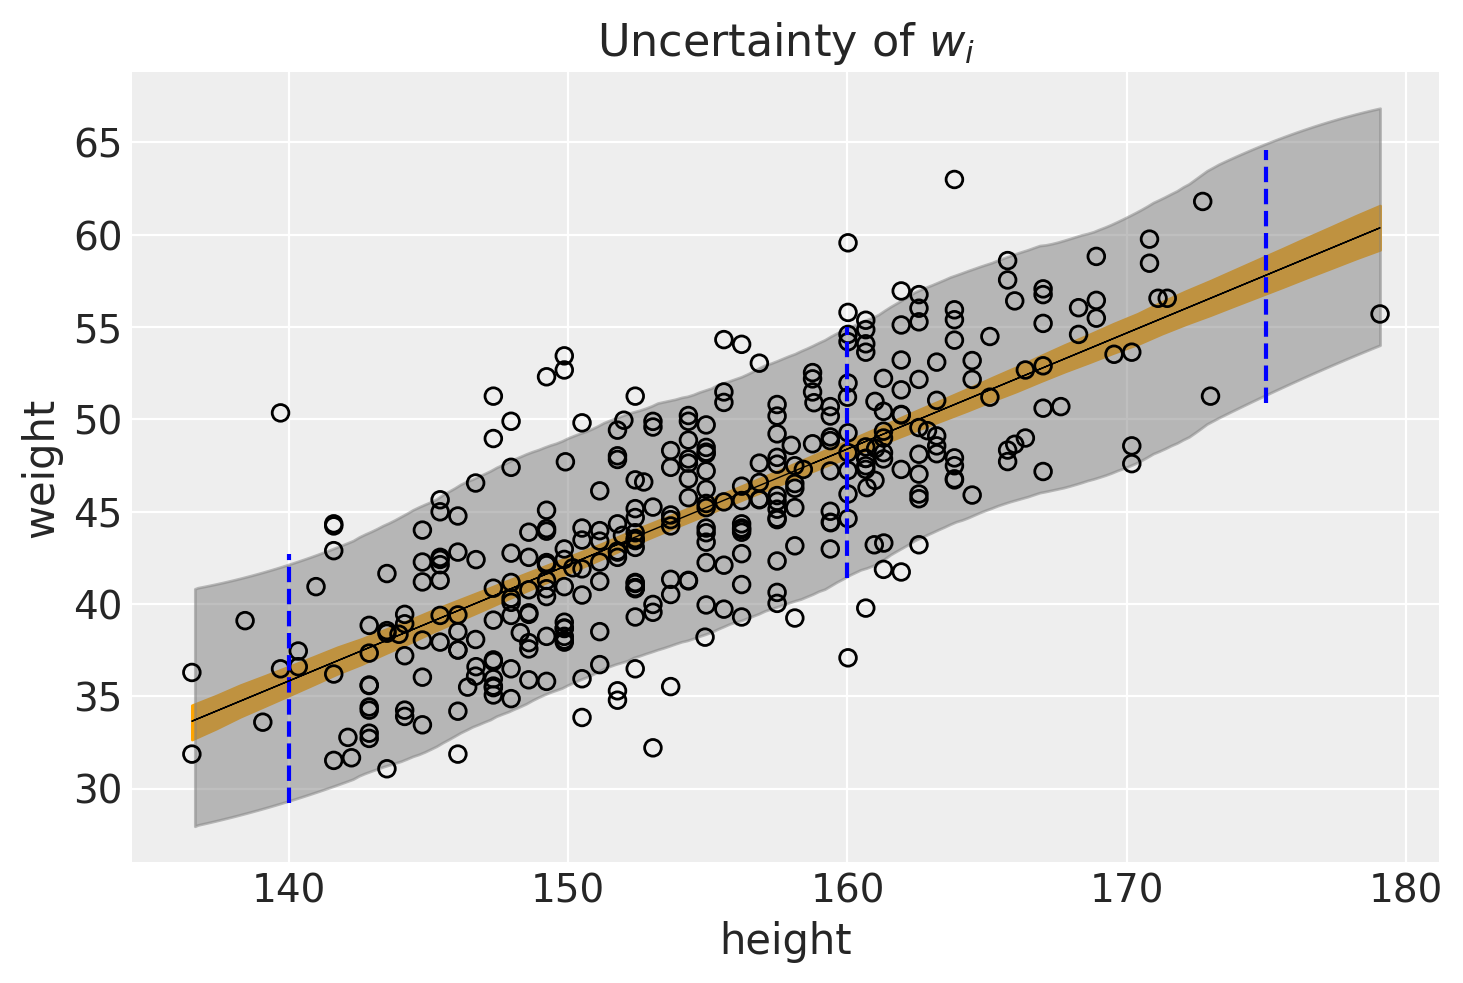

<IPython.core.display.Javascript object>

In [14]:
f, ax1 = plt.subplots()

# Plotting the overall mean line
ax1.plot(
    df_howell_ad['height'],
    idata_mq1_df[('posterior', 'a')].mean() + idata_mq1_df[('posterior', 'b')].mean() * (df_howell_ad['height'] - hbar),
    label="posterior mean line",
    linewidth=0.5,
    color="black",
)

# Uncertainty around mean
ax1.fill_between(
    np.linspace(df_howell_ad['height'].min(), df_howell_ad['height'].max()),
    cred_intervals[:, 0],
    cred_intervals[:, 1],
    alpha=1,
    color="orange"
)

# Uncertainty around all predictions
az.plot_hdi(df_howell_ad["height"], w_pred["w"], color='gray', ax=ax1)

# All raw data
ax1.scatter(df_howell_ad["height"], df_howell_ad["weight"], facecolors='none', edgecolors='k')

# Q1 predictions
for hi in [140, 160, 175]:
    pred_hi = predict_weight(hi)
    ax1.vlines(hi, ymin=pred_hi[1][0], ymax=pred_hi[1][1], linestyle='dashed', color='blue')

# Labeling
ax1.set_xlabel("height")
ax1.set_ylabel("weight")
ax1.set_title("Uncertainty of $w_i$")

In [15]:
for hi in [140, 160, 175]:
    print("Prediction at ", str(hi), predict_weight(hi))

Prediction at  140 (35.83402583863634, array([29.17492932, 42.796897  ]))
Prediction at  160 (48.394025838636345, array([41.18434225, 55.06138673]))
Prediction at  175 (57.81402583863634, array([50.8614644 , 64.46542948]))


<IPython.core.display.Javascript object>

# Q2

From the Howell1 dataset, consider only the people younger than 13 years
old. Estimate the causal association between age and weight. Assume that
age influences weight through two paths. First, age influences height, and
height influences weight. Second, age directly influences weight through agerelated
changes in muscle growth and body proportions. All of this implies
this causal model (DAG):

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


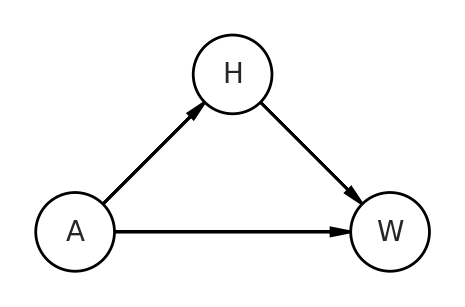

<IPython.core.display.Javascript object>

In [16]:
pipe_dag = CausalGraphicalModel(
    nodes=["A", "H", "W"],
    edges=[
        ("A", "H"),
        ("H", "W"),
        ("A", "W"),
    ],
)
pgm = daft.PGM()

coordinates = {
    "A": (0, 0),
    "H": (1, 1),
    "W": (2, 0)
}
for node in pipe_dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in pipe_dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()

Use a linear regression to estimate the total (not just direct) causal effect of
each year of growth on weight. Be sure to carefully consider the priors. Try
using prior predictive simulation to assess what they imply.

## Answer


The approach will be similar to Q1 except this time we're predicting with age. Since the question explicitly asks for the total effect of age, we do not have to condition on height. We simply regress weight on age. More specifically, he says to assess the causal effect of "each year of growth" meaning we do not standardize and don't have to subtract the mean.

In [17]:
df_howell_ch = df_howell[df_howell['age'] < 13].copy()
print("shape of df: ", df_howell_ch.shape)
df_howell_ch.head()

shape of df:  (146, 4)


,height,weight,age,male
18,121.92,19.617854,12.0,1
19,105.41,13.947954,8.0,0
20,86.36,10.489315,6.5,0
24,109.22,15.989118,7.0,0
30,114.30,17.860185,11.0,1


<IPython.core.display.Javascript object>

#### Attempt 1

Determining the prior was the main point of this exercise. An initial prior for $\alpha$ was tricky and it was tempting to look at the data. But I consulted [this website](https://www.babycenter.com/baby/baby-development/average-weight-and-growth-chart-for-babies-toddlers-and-beyo_10357633) instead to use a Normal(20,10). The other parameters can stay the same.

$$ W \sim \text{Normal}(\mu, \sigma) $$
$$ \mu = \alpha + \beta A  $$
$$ \alpha \sim \text{Normal}(20, 10) $$
$$ \beta \sim \text{LogNormal}(0, 1) $$
$$ \sigma \sim \text{Uniform}(0, 10) $$

In [18]:
with pm.Model() as mq2:

    # Priors are variables a, b, sigma (all stochastic)
    a = pm.Normal("a", mu=20, sd=10)
    b = pm.Lognormal("b", mu=0, sd=1)
    sigma = pm.Uniform("sigma", 0, 10)

    # linear model (mu is deterministic)
    mu = a + b * (df_howell_ch['age'])

    # likelihood
    w = pm.Normal("w", mu=mu, sd=sigma, observed=df_howell_ch['weight'])

    idata_mq2 = pm.sample(1000, tune=1000, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


<IPython.core.display.Javascript object>

In [19]:
az.summary(idata_mq2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,7.478,0.381,6.877,8.087,0.009,0.006,1827.0,1827.0,1828.0,1921.0,1.0
b,1.337,0.057,1.241,1.422,0.001,0.001,1809.0,1809.0,1802.0,1748.0,1.0
sigma,2.564,0.155,2.325,2.819,0.003,0.002,2231.0,2231.0,2228.0,1900.0,1.0


<IPython.core.display.Javascript object>

He asks us to assess the effect of the priors. Already I can see that my initial choice probably wasn't great because negative weights are possible.

In [20]:
with mq2:
    # prior_pred2 = pm.sample_prior_predictive(samples=20, var_names=['a', 'b', 'sigma', 'w'])  # easier to see what's going on
    prior_pred2 = pm.sample_prior_predictive(samples=100, var_names=['a', 'b', 'sigma', 'w'])

<IPython.core.display.Javascript object>

In [21]:
for key in prior_pred2.keys():
    print(key, prior_pred2[key].shape)

sigma (100,)
w (100, 146)
b (100,)
a (100,)


<IPython.core.display.Javascript object>

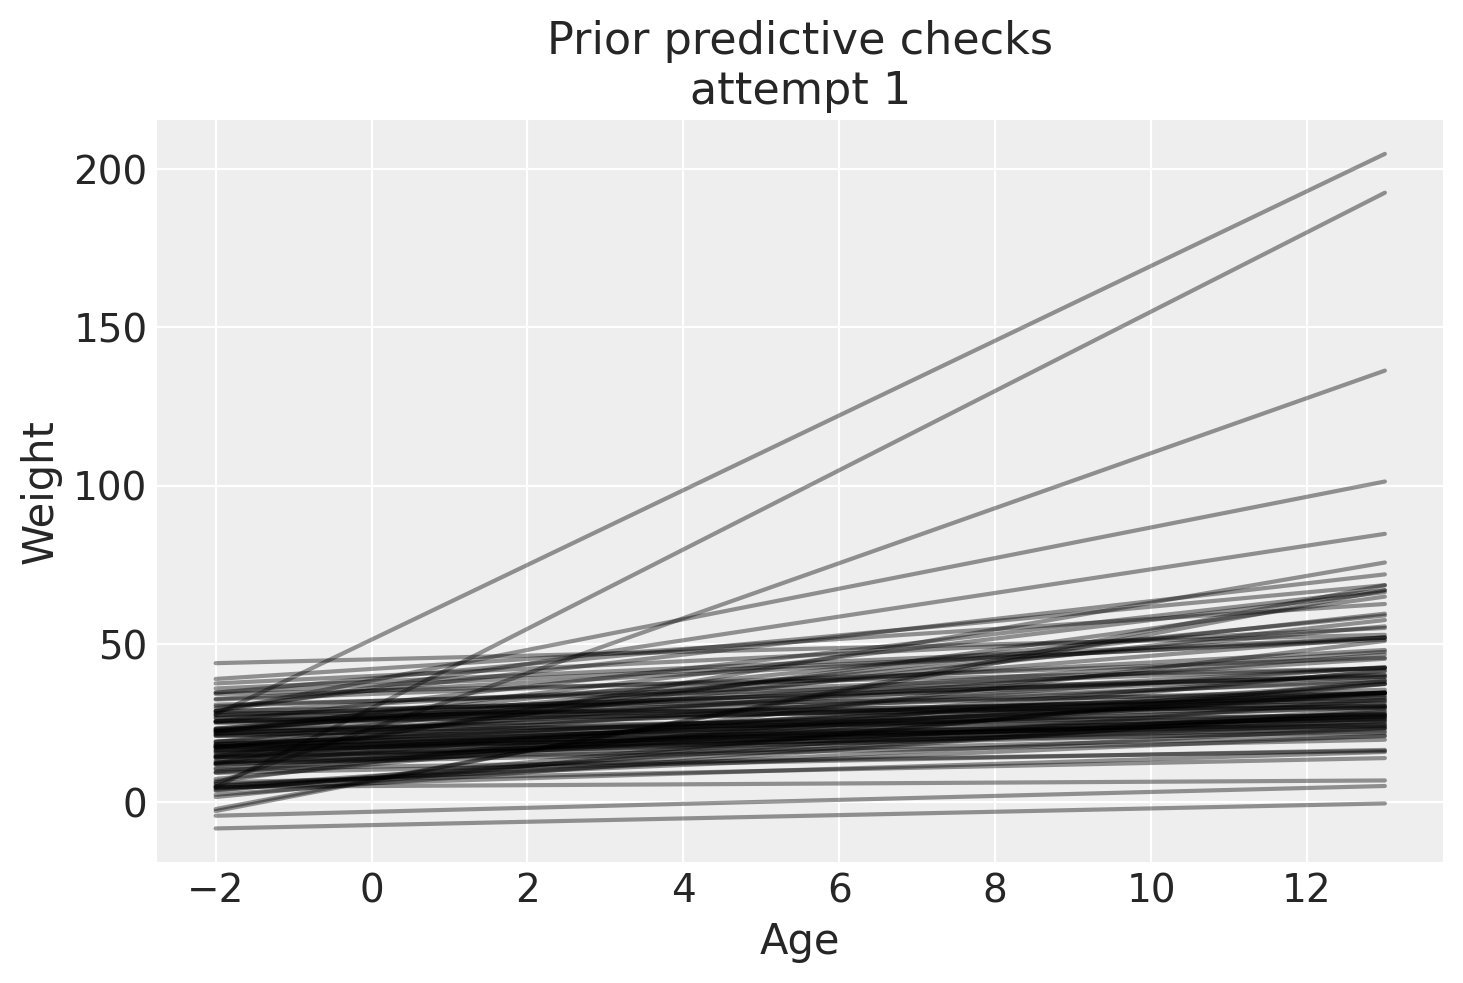

<IPython.core.display.Javascript object>

In [22]:
# code modified from pymc docs
f, ax1 = plt.subplots()

x = np.linspace(-2, 13, 50)

for a, b in zip(prior_pred2["a"], prior_pred2["b"]):
    y = a + b * x
    ax1.plot(x, y, c="k", alpha=0.4)

ax1.set_xlabel("Age")
ax1.set_ylabel("Weight")
ax1.set_title("Prior predictive checks\nattempt 1");

In [23]:
prior_pred2['w'].min()

-19.493074666173097

<IPython.core.display.Javascript object>

The predictions look mostly reasonable except there are some predictions of negative weight. We need to set the intercept so that negative weights are not considered.

#### Attempt 2

From looking at this [StatsExchange post](https://math.stackexchange.com/questions/1335829/default-positive-non-negative-probability-distribution/1335872), I'll consider a gamma distribution. The [wikipedia page](https://en.wikipedia.org/wiki/Gamma_distribution) and the `scipy.stats` [page](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html) for implementation.

I'd like to keep the distribution centered over 20 when I try a gamma but I don't have an intuition for how to paramaterize its variance. The mean of a gamma distribution is `a*b`. In the `scipy.stats` function below, `b` is represented as `1/scale`. I'll try a few values.

I'll also try different priors for $\sigma$. Note that the parameter $\lambda$ is represented as `1/scale` in the `scipy.stats` function.

Gamma(1, 0.05)
Gamma(2, 0.1)
Gamma(3, 0.15)


[Text(0.5, 0, 'standard deviation of weight'),
 Text(0, 0.5, 'PDF'),
 Text(0.5, 1.0, 'Evaluating different priors for $\\sigma$')]

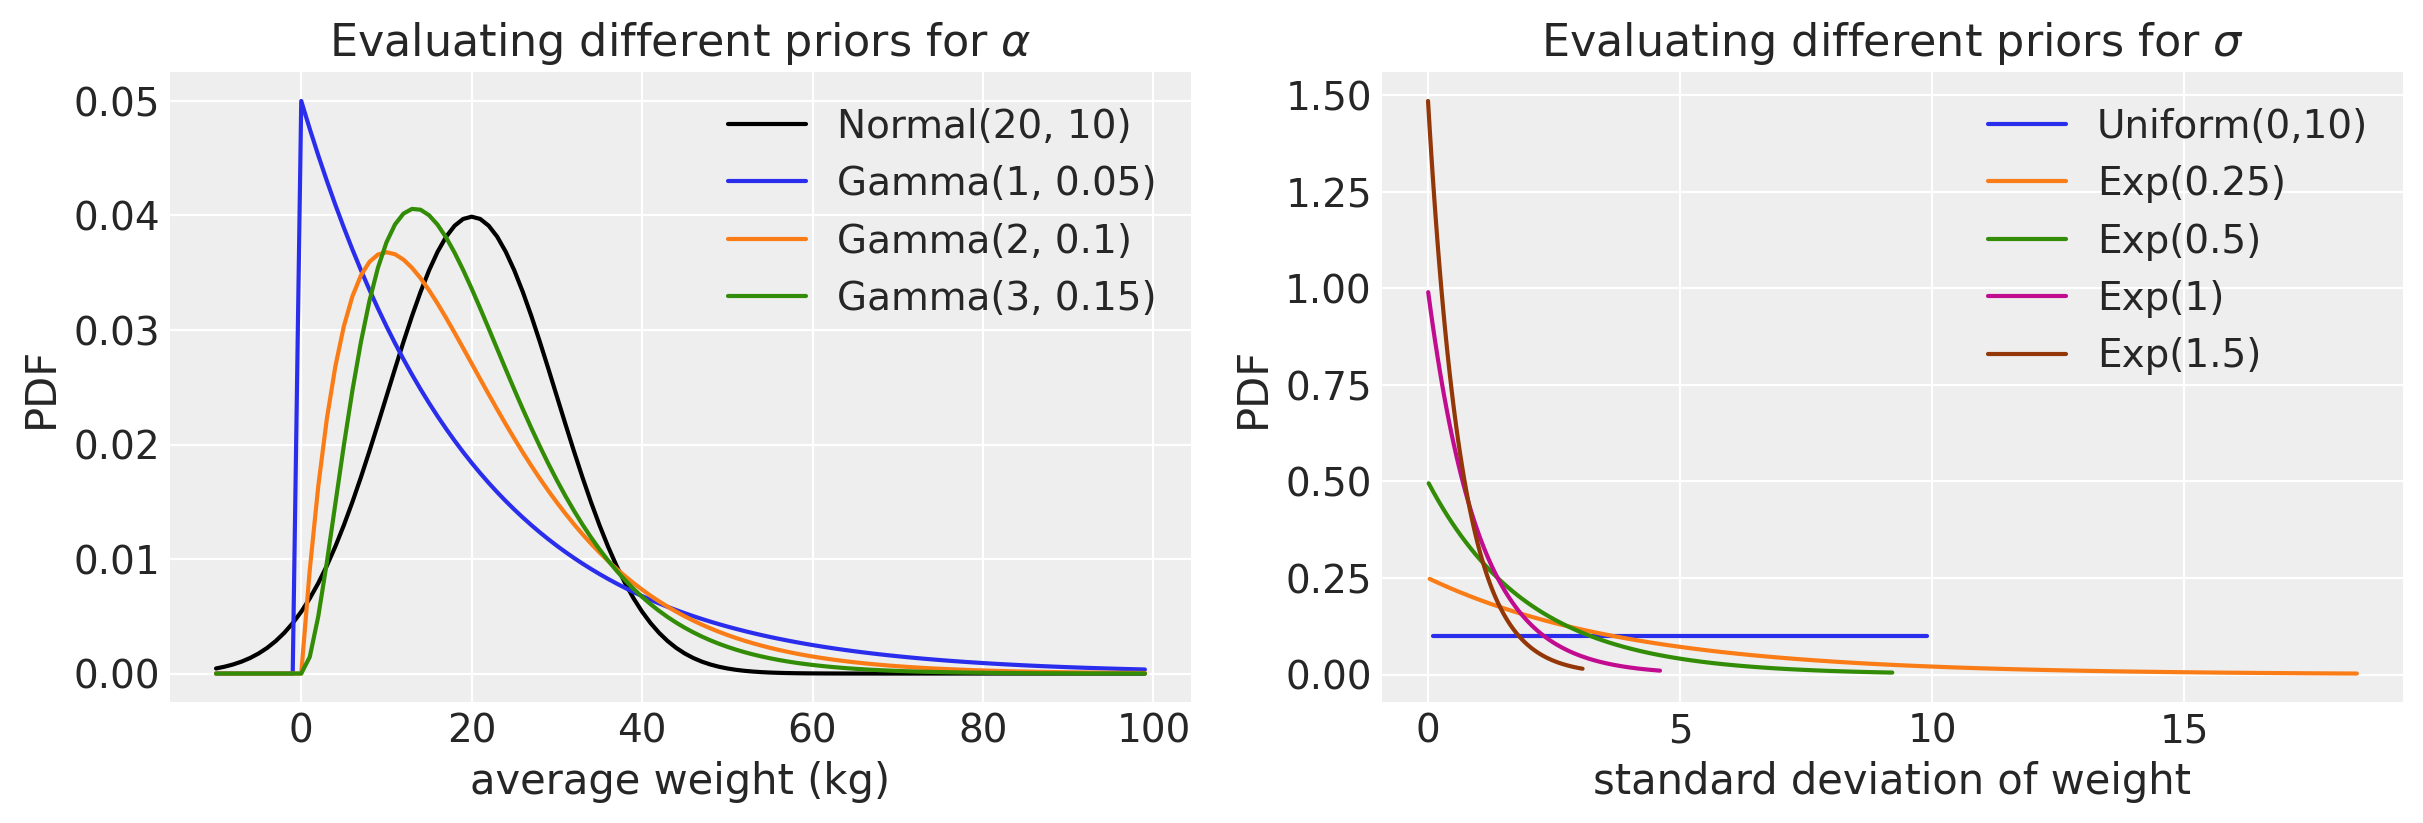

<IPython.core.display.Javascript object>

In [24]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

xrange = range(-10, 100)

# Normal distribution (attempt 1)
ax1.plot(
    xrange,
    stats.norm.pdf(x=xrange, loc=20, scale=10),
    color='black',
    label='Normal(20, 10)'
    )

# Different gamma distributions
test_vals = range(1, 4, 1)
for a in test_vals:
    b = round(a / 20, 2)   # mean = a/b
    ax1.plot(
        xrange,
        stats.gamma.pdf(x=xrange, a=a, scale=1/b),
        label=f'Gamma({a}, {b})'
    )
    print(f'Gamma({a}, {b})')

ax1.set(xlabel='average weight (kg)', ylabel='PDF', title=r'Evaluating different priors for $\alpha$')
ax1.legend()

# Different sigma distributions

# uniform
x1 = np.linspace(stats.uniform.ppf(0.01, scale=10),
                stats.uniform.ppf(0.99, scale=10), 100)
ax2.plot(x1, stats.uniform.pdf(x1, scale=10), label='Uniform(0,10)')

# exponential
lambdas = [0.25, 0.5, 1, 1.5]    # in scipy.stats, scale is 1/lambda
for lamb in lambdas:
    x3 = np.linspace(stats.expon.ppf(0.01, scale=1/lamb),
                    stats.expon.ppf(0.99, scale=1/lamb), 100)
    ax2.plot(x3, stats.expon.pdf(x3, scale=1/lamb), label=f'Exp({lamb})')
    ax2.legend()

ax2.set(xlabel='standard deviation of weight', ylabel='PDF', title=r'Evaluating different priors for $\sigma$')

On the left, it's clear that the gamma distributions do a much better job than the normal distribution in constraining the weights to be positive. Even if I had chosen a stricter SD (Normal(20, 5)), a normal distribution technically allows negative weights. I'm going to use the Gamma(2, 0.1) prior because of the long right tail.

On the right, the uniform prior might allow too much possibility for a high standard deviation. I'll use an Exp(1).

Here's the new set of equations.

$$ W \sim \text{Normal}(\mu, \sigma) $$
$$ \mu = \alpha + \beta A  $$
$$ \alpha \sim \text{Gamma}(2, 0.1) $$
$$ \beta \sim \text{LogNormal}(0, 1) $$
$$ \sigma \sim \text{Exp}(1) $$

In [25]:
with pm.Model() as mq2b:

    # Priors are variables a, b, sigma (all stochastic)
    a = pm.Gamma("a", alpha=2, beta=0.1)
    b = pm.Lognormal("b", mu=0, sd=1)
    sigma = pm.Exponential("sigma", 1)

    # linear model (mu is deterministic)
    mu = a + b * (df_howell_ch['age'])

    # likelihood
    w = pm.Normal("w", mu=mu, sd=sigma, observed=df_howell_ch['weight'])

    idata_mq2b = pm.sample(1000, tune=1000, return_inferencedata=True, progressbar=False, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


<IPython.core.display.Javascript object>

We can look at the prior predictives again.

In [26]:
with mq2b:
    prior_pred2b = pm.sample_prior_predictive(samples=100, var_names=['a', 'b', 'sigma', 'w'])

<IPython.core.display.Javascript object>

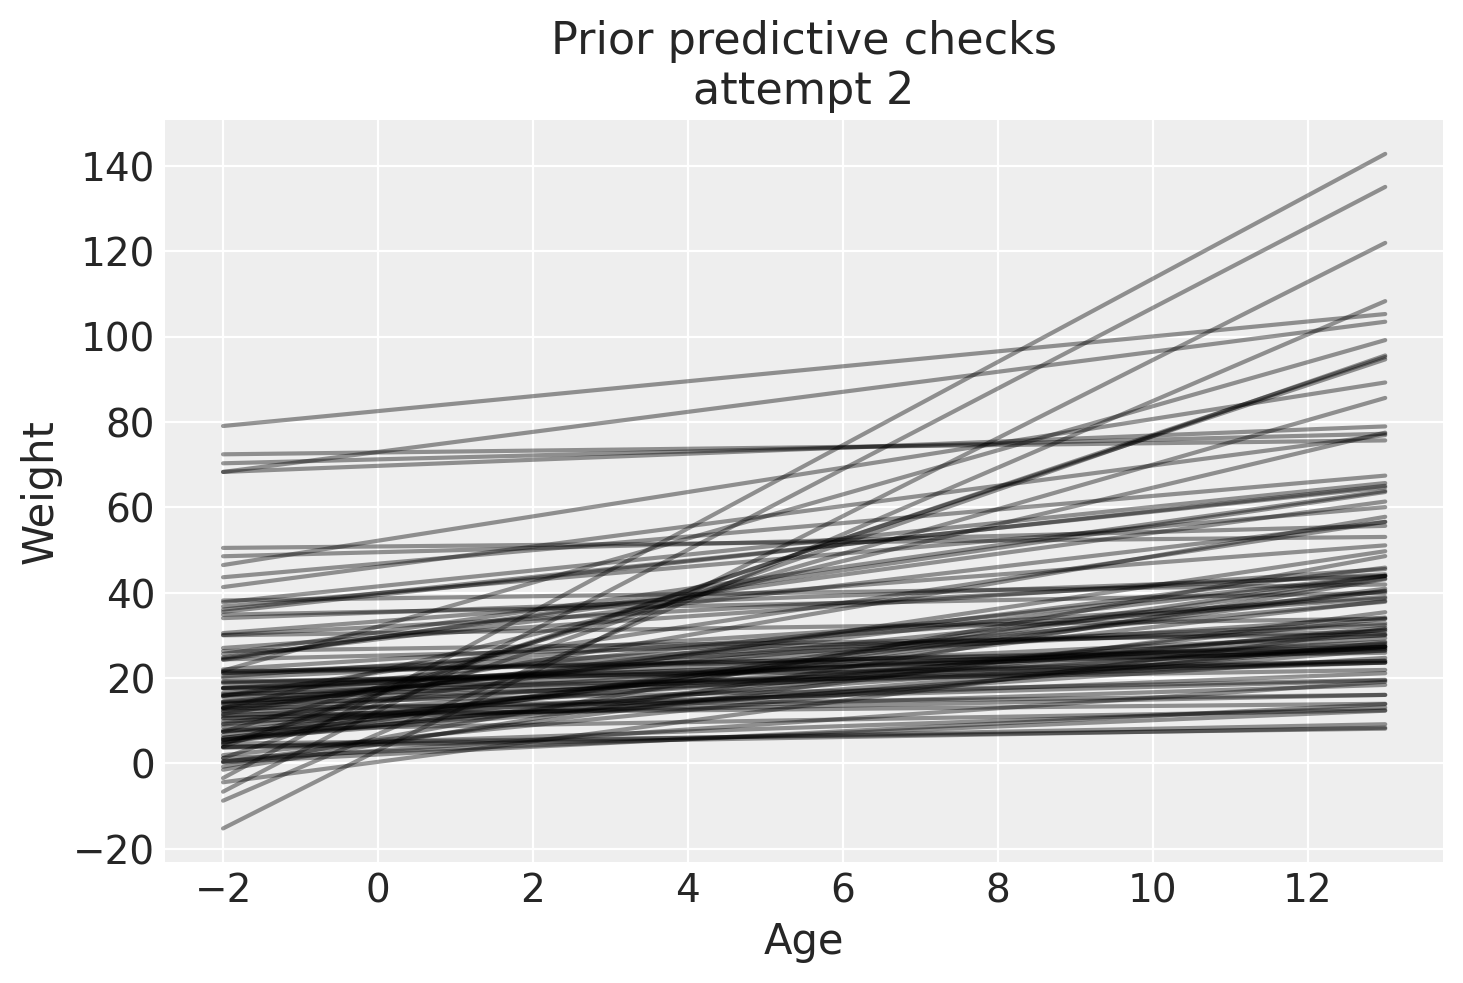

<IPython.core.display.Javascript object>

In [27]:
# code modified from pymc docs
f, ax1 = plt.subplots()

x = np.linspace(-2, 13, 50)

for a, b in zip(prior_pred2b["a"], prior_pred2b["b"]):
    y = a + b * x
    ax1.plot(x, y, c="k", alpha=0.4)

ax1.set_xlabel("Age")
ax1.set_ylabel("Weight")
ax1.set_title("Prior predictive checks\nattempt 2");

In [28]:
prior_pred2b['a'].min(), prior_pred2b['b'].min(), prior_pred2b['w'].min()

(0.35641419415438086, 0.17000576802937012, -3.5230509998132256)

<IPython.core.display.Javascript object>

I'm not happy that it still allows a negative weight prediction, but I'll roll with it. What do our summaries tell us?

In [29]:
az.summary(idata_mq2b)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,7.461,0.367,6.877,8.053,0.010,0.007,1472.0,1472.0,1464.0,1356.0,1.0
b,1.339,0.056,1.251,1.426,0.001,0.001,1412.0,1399.0,1411.0,1691.0,1.0
sigma,2.540,0.150,2.313,2.779,0.003,0.002,2487.0,2487.0,2469.0,2092.0,1.0


<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

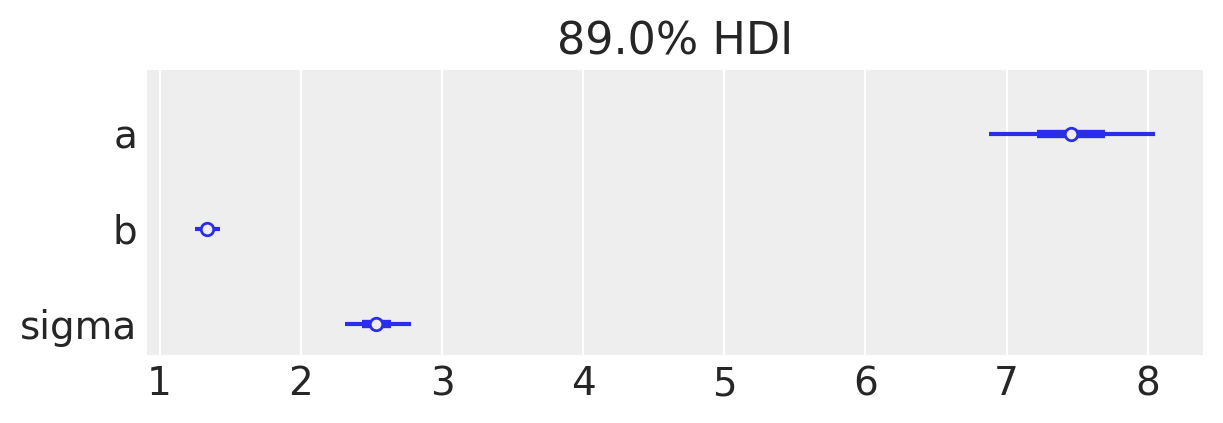

<IPython.core.display.Javascript object>

In [30]:
f, ax1 = plt.subplots(figsize=(6,2))
az.plot_forest(idata_mq2b, combined=True, ax=ax1)

First, the average birth weight is roughly 7.5 kg as estimated by our model. This isn't far off from looking directly at the data.

In [31]:
df_howell_ch.loc[df_howell_ch['age'] < 1, 'weight'].mean()

7.269284291666668

<IPython.core.display.Javascript object>

The beta coefficient tells us the total effect of one additional year on weight. An additional year of age means adds about 1.3 kg of weight.

In [32]:
# Predict weights (using whole posterior, including sigma)
with mq2b:
    w_pred2b = pm.sample_posterior_predictive(idata_mq2b, 200)

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/pymc3/sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


<IPython.core.display.Javascript object>

NameError: name 'idata_mq2b_df' is not defined

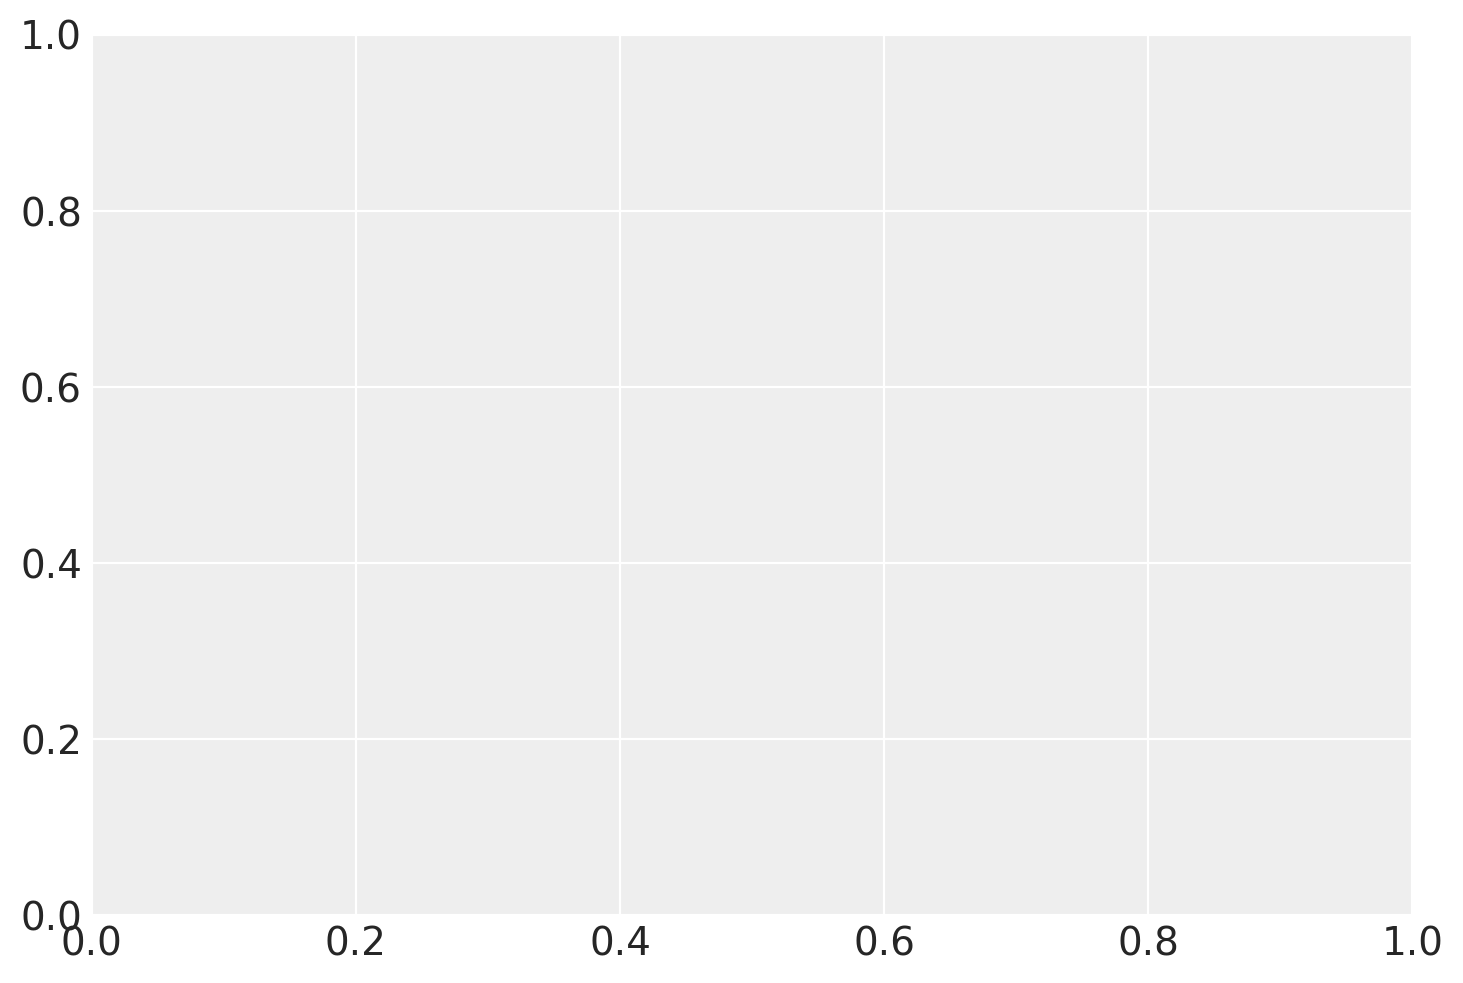

<IPython.core.display.Javascript object>

In [33]:
f, ax1 = plt.subplots()

# Plotting the overall mean line
ax1.plot(
    df_howell_ch['age'],
    idata_mq2b_df[('posterior', 'a')].mean() + idata_mq2b_df[('posterior', 'b')].mean() * (df_howell_ch['age']),
    label="posterior mean line",
    linewidth=0.5,
    color="blue",
)

# Uncertainty around all predictions
az.plot_hdi(df_howell_ch['age'], w_pred2b["w"], color='gray', ax=ax1)

# All raw data
ax1.scatter(df_howell_ch['age'], df_howell_ch["weight"], facecolors='none', edgecolors='k')

# Labeling
ax1.set_xlabel("age")
ax1.set_ylabel("weight")
ax1.set_title("Uncertainty of $w_i$\n(children)")

With more time to work on this problem:
- I'd tease apart the direct and indirect effect.
- Use a Gamma prior on the outcome so negative weight predictions would never happen.

# Q3

Now suppose the causal association between age and weight might be different
for boys and girls. Use a single linear regression, with a categorical
variable for sex, to estimate the total causal effect of age on weight separately
for boys and girls. How do girls and boys differ? Provide one or more posterior
contrasts as a summary.

## Answer

I'm assuming that this is still using the filtered dataset containing children only. In this case, we can build a new model, using a categorical variable on sex.

$$ W \sim \text{Normal}(\mu, \sigma) $$
$$ \mu = \alpha_{\text{[sex]}} + \beta_{\text{[sex]}} A  $$
$$ \alpha \sim \text{Gamma}(2, 0.1) $$
$$ \beta \sim \text{LogNormal}(0, 1) $$
$$ \sigma \sim \text{Exp}(1) $$

We can do things the same, but just need to account for these indexes.

In [ ]:
with pm.Model() as mq3:

    # Priors are variables a, b, sigma (all stochastic)
    a = pm.Gamma("a", alpha=2, beta=0.1, shape=2)
    b = pm.Lognormal("b", mu=0, sd=1, shape=2)
    sigma = pm.Exponential("sigma", 1)

    # linear model (mu is deterministic)
    mu = a[df_howell_ch['male']] + b[df_howell_ch['male']] * (df_howell_ch['age'])

    # likelihood
    w = pm.Normal("w", mu=mu, sd=sigma, observed=df_howell_ch['weight'])

    idata_mq3 = pm.sample(1000, tune=1000, return_inferencedata=True, progressbar=False, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


<IPython.core.display.Javascript object>

### Posterior (parameters)

In [ ]:
az.summary(idata_mq3)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],7.096,0.486,6.324,7.872,0.011,0.008,1978.0,1978.0,1984.0,2137.0,1.0
a[1],7.928,0.509,7.141,8.765,0.012,0.008,1823.0,1800.0,1830.0,2143.0,1.0
b[0],1.284,0.074,1.167,1.403,0.002,0.001,1955.0,1955.0,1959.0,1858.0,1.0
b[1],1.381,0.079,1.261,1.508,0.002,0.001,1853.0,1853.0,1854.0,1872.0,1.0
sigma,2.457,0.147,2.212,2.677,0.003,0.002,2999.0,2990.0,2940.0,2428.0,1.0


<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

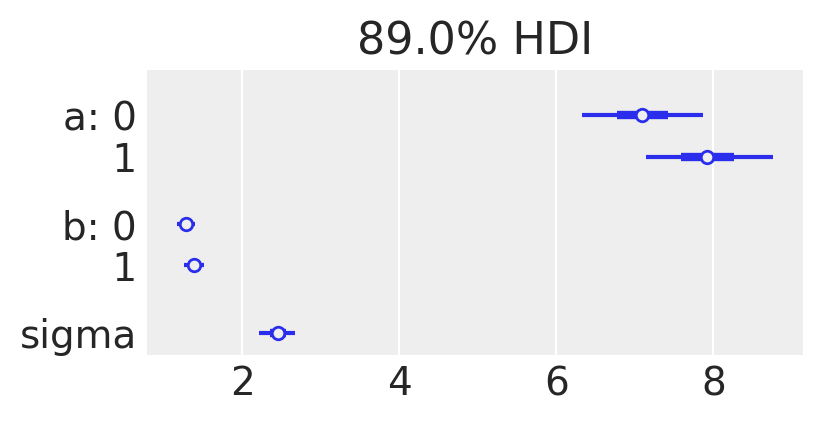

<IPython.core.display.Javascript object>

In [ ]:
f, ax1 = plt.subplots(figsize=(4, 2))
az.plot_forest(idata_mq3, combined=True, ax=ax1)

To get the difference in the effects of gender for these parameters, we need to calculate contrasts on the posteriors.

In [ ]:
# make posterior accessible
idata_mq3_df = idata_mq3.to_dataframe()
idata_mq3_df.head()

,chain,draw,"(posterior, a[0], 0)","(posterior, a[1], 1)","(posterior, b[0], 0)","(posterior, b[1], 1)","(posterior, sigma)","(log_likelihood, w[0], 0)","(log_likelihood, w[100], 100)","(log_likelihood, w[101], 101)",...,"(sample_stats, step_size_bar)","(sample_stats, lp)","(sample_stats, process_time_diff)","(sample_stats, depth)","(sample_stats, energy)","(sample_stats, mean_tree_accept)","(sample_stats, energy_error)","(sample_stats, perf_counter_diff)","(sample_stats, tree_size)","(sample_stats, perf_counter_start)"
0,0,0,6.758398,7.466584,1.350837,1.356999,2.646657,-3.111352,-2.004529,-2.137672,...,0.320758,-346.028778,0.000864,3,349.616027,0.733034,0.394434,0.000864,7.0,11.711500
1,0,1,6.214390,7.050920,1.398557,1.545268,2.583371,-4.543862,-1.947034,-2.172696,...,0.320758,-346.832482,0.000868,3,349.187563,0.995033,-0.262369,0.000868,7.0,11.712466
2,0,2,8.179265,8.258114,1.153008,1.371307,2.258904,-4.278438,-2.149684,-2.132098,...,0.320758,-346.656869,0.002001,4,350.527551,0.989454,-0.016566,0.002000,15.0,11.713434
3,0,3,7.628648,8.008153,1.163867,1.339821,2.496978,-3.435036,-2.087723,-2.327173,...,0.320758,-344.350777,0.001468,3,347.155499,0.999099,-0.097455,0.001468,7.0,11.715604
4,0,4,7.870026,8.010759,1.184818,1.332323,2.527798,-3.348004,-2.092481,-2.181853,...,0.320758,-344.440023,0.001058,3,346.240752,0.916597,0.002532,0.001058,7.0,11.717333


<IPython.core.display.Javascript object>

In [ ]:
diff_a = idata_mq3_df[('posterior', 'a[1]', 1)] - idata_mq3_df[('posterior', 'a[0]', 0)]
diff_b = idata_mq3_df[('posterior', 'b[1]', 1)] - idata_mq3_df[('posterior', 'b[0]', 0)]

<IPython.core.display.Javascript object>

In [ ]:
az.summary(np.array(diff_a))

arviz - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,0.832,0.709,-0.32,1.963,0.017,0.012,1827.0,1691.0,1834.0,2127.0,NaN


<IPython.core.display.Javascript object>

This tells us that being a male adds 0.833 kg of weight on average at birth, although the 89% interval is very wide.

In [ ]:
az.summary(np.array(diff_b))

arviz - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,0.097,0.108,-0.077,0.265,0.003,0.002,1846.0,1721.0,1845.0,2125.0,NaN


<IPython.core.display.Javascript object>

This tells us that with an additional year of age, a male adds 0.098 kg more of weight on average than a female. Again, the 89% HPDI is wide.

In [ ]:
idata_mq3_df[('posterior', 'a[0]', 0)]

0       6.758398
1       6.214390
2       8.179265
3       7.628648
4       7.870026
          ...   
3995    6.933705
3996    7.825234
3997    6.898595
3998    7.229444
3999    6.905071
Name: (posterior, a[0], 0), Length: 4000, dtype: float64

<IPython.core.display.Javascript object>

[Text(0.5, 0, 'beta\n(male-female)'), Text(0.5, 1.0, 'beta')]

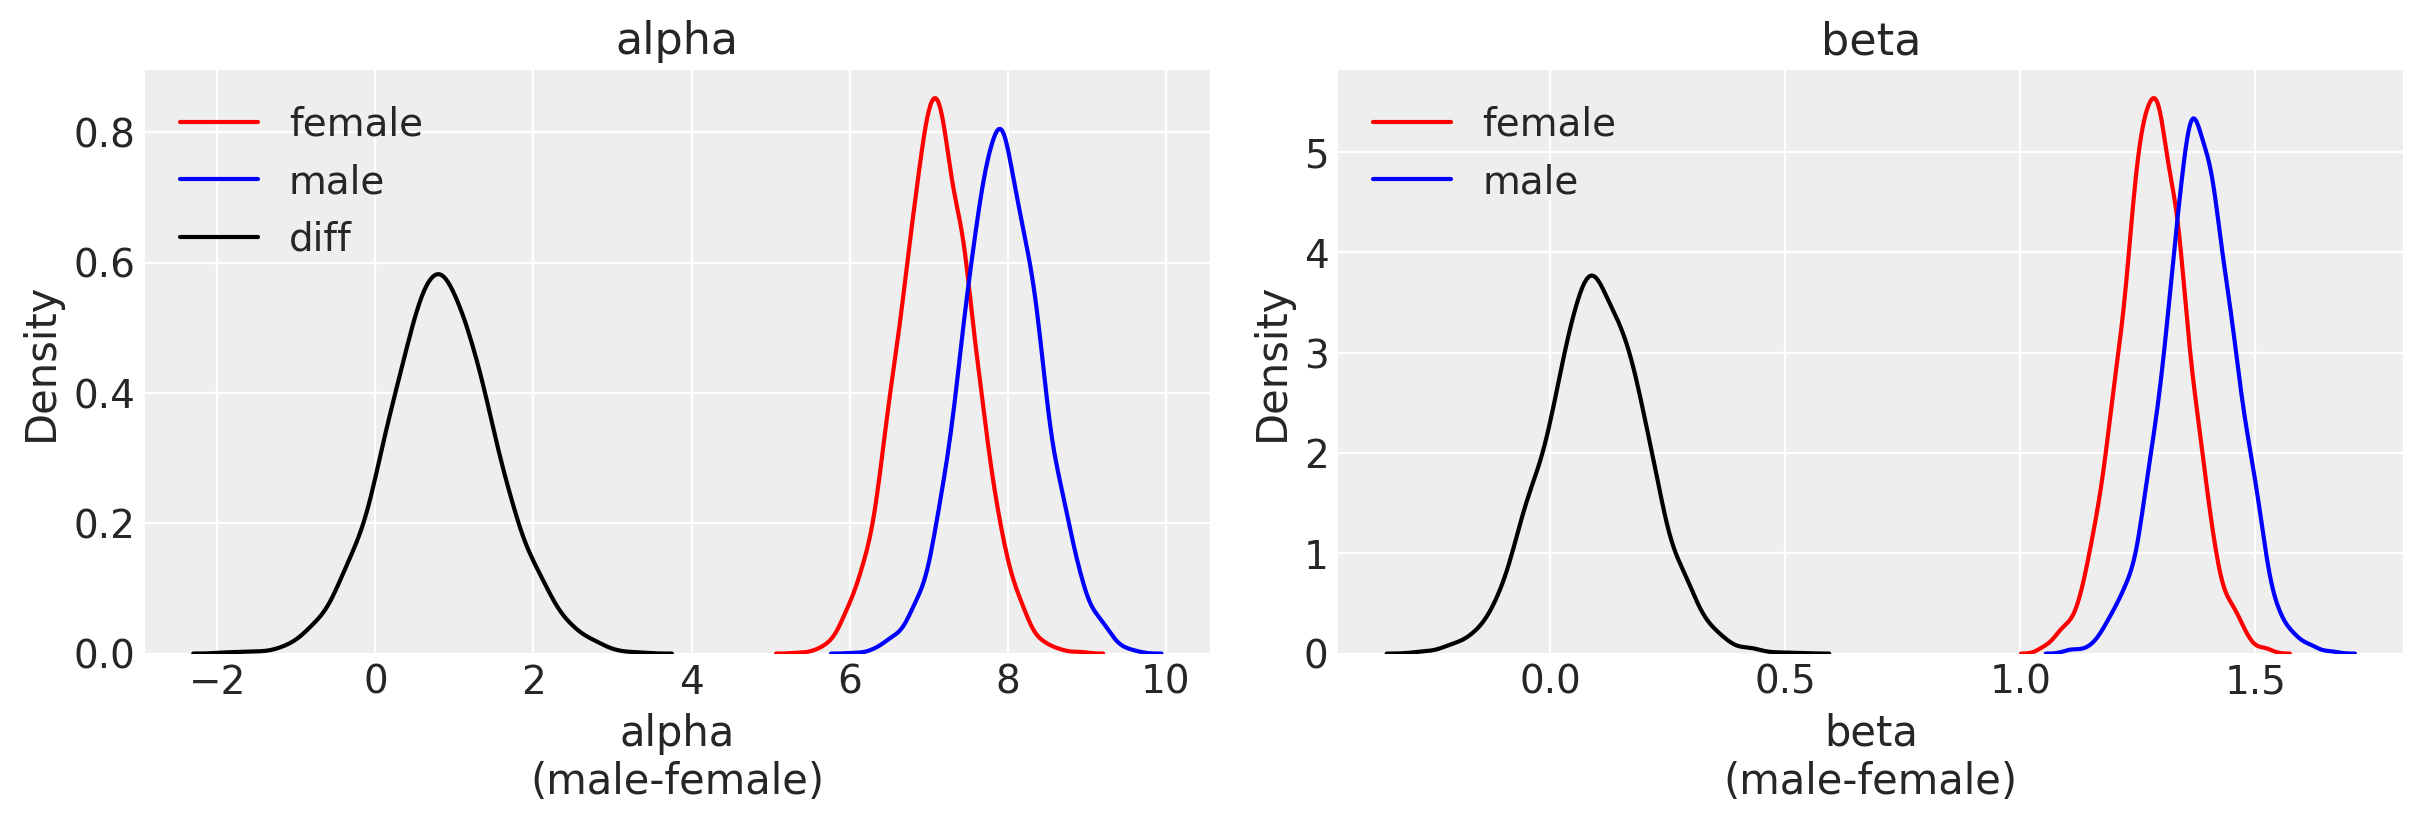

<IPython.core.display.Javascript object>

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.kdeplot(idata_mq3_df[('posterior', 'a[0]', 0)], ax=ax1, color='red', label='female')
sns.kdeplot(idata_mq3_df[('posterior', 'a[1]', 1)], ax=ax1, color='blue', label='male')
sns.kdeplot(diff_a, ax=ax1, color='k', label='diff')
ax1.legend()
ax1.set(xlabel='alpha\n(male-female)', title='alpha')

sns.kdeplot(idata_mq3_df[('posterior', 'b[0]', 0)], ax=ax2, color='red', label='female')
sns.kdeplot(idata_mq3_df[('posterior', 'b[1]', 1)], ax=ax2, color='blue', label='male')
sns.kdeplot(diff_b, color='k', ax=ax2)
ax2.legend()
ax2.set(xlabel='beta\n(male-female)', title='beta')

### Posterior predictions

In [ ]:
idata_mq3_df[('posterior', 'b[0]', 0)]

0       1.350837
1       1.398557
2       1.153008
3       1.163867
4       1.184818
          ...   
3995    1.366292
3996    1.223308
3997    1.242934
3998    1.292191
3999    1.253800
Name: (posterior, b[0], 0), Length: 4000, dtype: float64

<IPython.core.display.Javascript object>

In [ ]:
cred_intervals_f = np.array(
    [
        az.hdi(
            np.array(idata_mq3_df[('posterior', 'a[0]', 0)])
            + np.array(idata_mq3_df[('posterior', 'b[0]', 0)] * age)
        )
        for age in np.linspace(df_howell_ch['age'].min(), df_howell_ch['age'].max())
    ]
)

cred_intervals_m = np.array(
    [
        az.hdi(
            np.array(idata_mq3_df[('posterior', 'a[1]', 1)])
            + np.array(idata_mq3_df[('posterior', 'b[1]', 1)] * age)
        )
        for age in np.linspace(df_howell_ch['age'].min(), df_howell_ch['age'].max())
    ]
)

# Take a look at credibility intervals
cred_intervals_f[0:5, :]

array([[6.32430163, 7.87203968],
       [6.66084882, 8.16285378],
       [6.99854759, 8.45241966],
       [7.334018  , 8.74050456],
       [7.66570303, 9.02812502]])

<IPython.core.display.Javascript object>

In [ ]:
# Predict weights (using whole posterior, including sigma)
with mq3:
    w_pred3 = pm.sample_posterior_predictive(idata_mq3, var_names=['a', 'b', 'w'], size=200)

<IPython.core.display.Javascript object>

In [ ]:
w_pred3['a'].shape, w_pred3['b'].shape, w_pred3['w'].shape

((4000, 2), (4000, 2), (4000, 200, 146))

<IPython.core.display.Javascript object>

In [ ]:
idata_mq3_df.columns[0:10]

Index([                          'chain',                            'draw',
                ('posterior', 'a[0]', 0),          ('posterior', 'a[1]', 1),
                ('posterior', 'b[0]', 0),          ('posterior', 'b[1]', 1),
                  ('posterior', 'sigma'),     ('log_likelihood', 'w[0]', 0),
       ('log_likelihood', 'w[100]', 100), ('log_likelihood', 'w[101]', 101)],
      dtype='object')

<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


Text(0.5, 1.0, 'Uncertainty of $w_i$ by gender\n(children, unsure if this is right)')

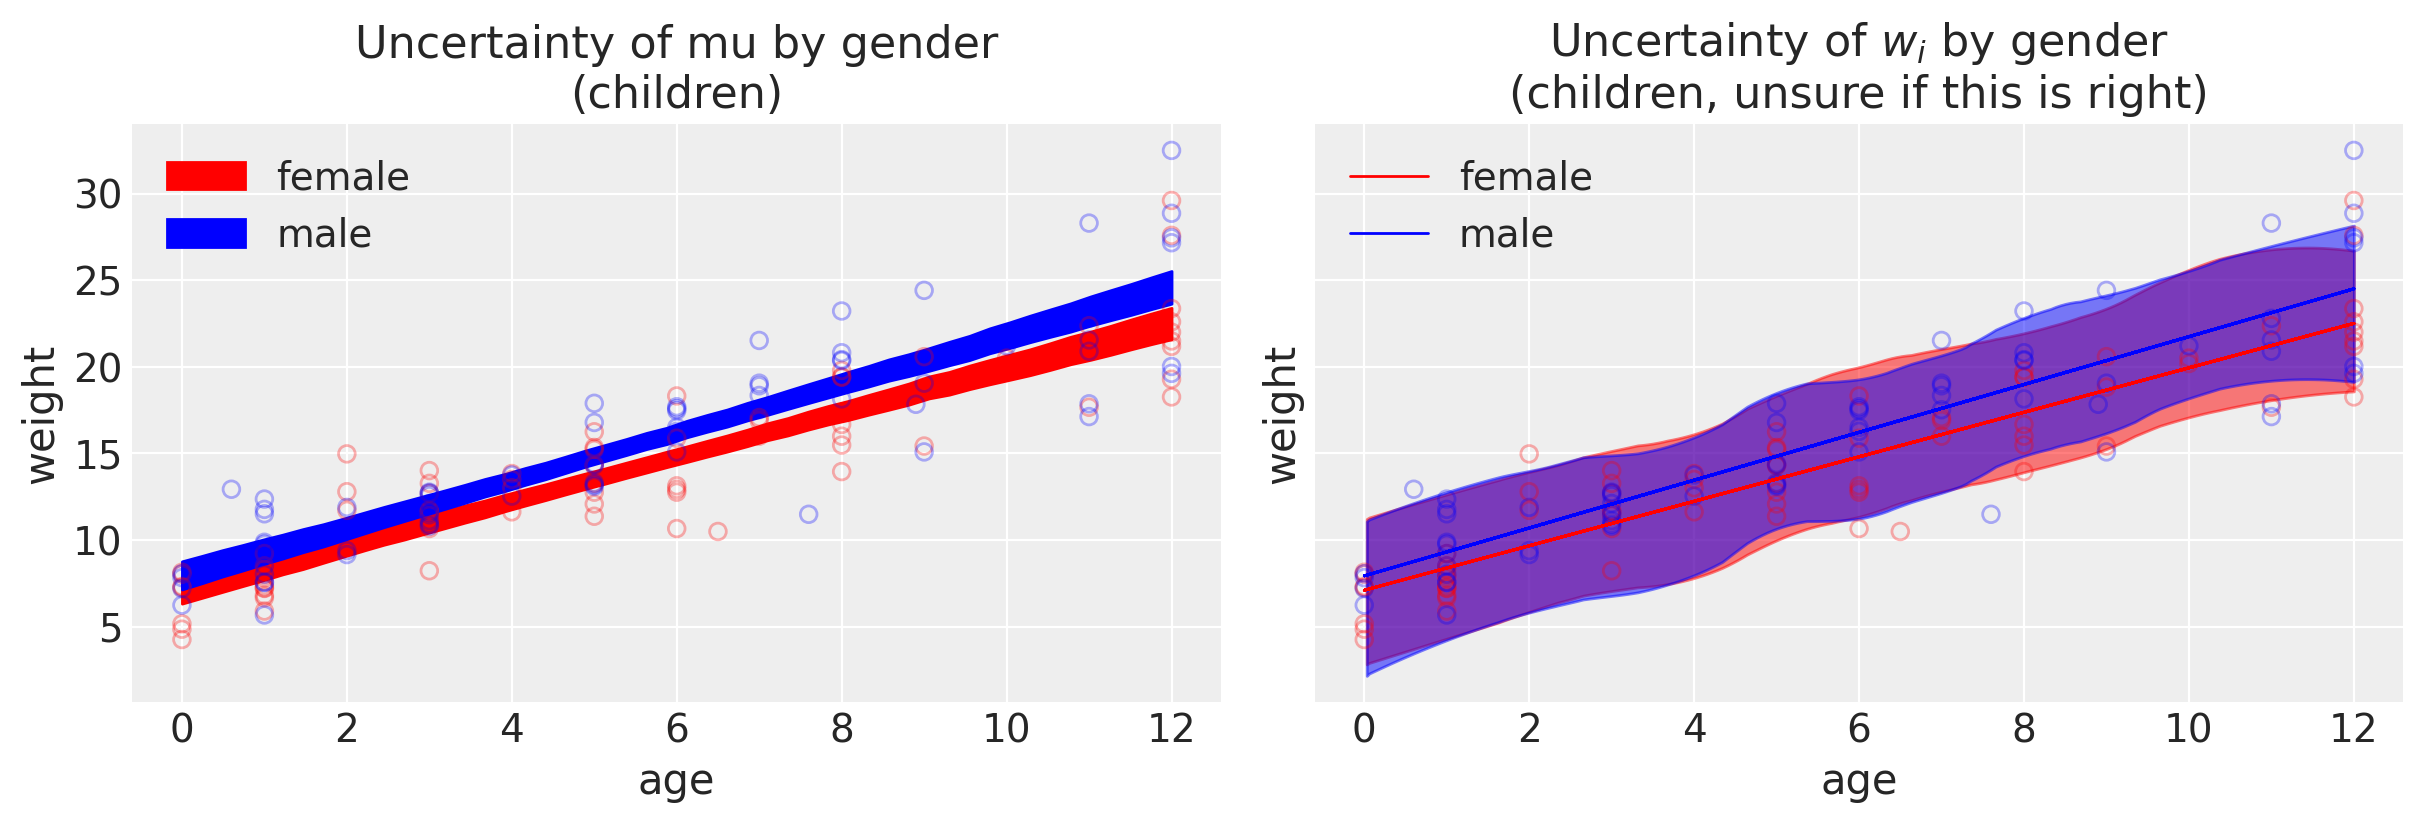

<IPython.core.display.Javascript object>

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

f_index = df_howell_ch[df_howell_ch['male']==0].index
m_index = df_howell_ch[df_howell_ch['male']==1].index

# ax1 ---------------------------------------------------------
# Uncertainty around mean
ax1.fill_between(
    np.linspace(df_howell_ch['age'].min(), df_howell_ch['age'].max()),
    cred_intervals_f[:, 0],
    cred_intervals_f[:, 1],
    alpha=1,
    color="red",
    label='female'
)

ax1.fill_between(
    np.linspace(df_howell_ch['age'].min(), df_howell_ch['age'].max()),
    cred_intervals_m[:, 0],
    cred_intervals_m[:, 1],
    alpha=1,
    color="blue",
    label='male'
)

# All raw data
ax1.scatter(df_howell_ch.loc[f_index, 'age'], df_howell_ch.loc[f_index, "weight"], facecolors='none', edgecolors='red', alpha=0.3)
ax1.scatter(df_howell_ch.loc[m_index, 'age'], df_howell_ch.loc[m_index, "weight"], facecolors='none', edgecolors='blue', alpha=0.3)

# Labeling
ax1.legend()
ax1.set_xlabel("age")
ax1.set_ylabel("weight")
ax1.set_title("Uncertainty of mu by gender\n(children)")

# ax2 ---------------------------------------------------------
# Plotting the overall mean line
ax2.plot(
    df_howell_ch.loc[f_index, 'age'],
    idata_mq3_df[('posterior', 'a[0]', 0)].mean() + idata_mq3_df[('posterior', 'b[0]', 0)].mean() * (df_howell_ch.loc[f_index, 'age']),
    label="female",
    linewidth=1,
    color="red",
)

ax2.plot(
    df_howell_ch.loc[m_index, 'age'],
    idata_mq3_df[('posterior', 'a[1]', 1)].mean() + idata_mq3_df[('posterior', 'b[1]', 1)].mean() * (df_howell_ch.loc[m_index, 'age']),
    label="male",
    linewidth=1,
    color="blue",
)

# Uncertainty around all predictions
az.plot_hdi(df_howell_ch['age'], w_pred3['w'][0, :, :], color='red', ax=ax2)
az.plot_hdi(df_howell_ch['age'], w_pred3['w'][1, :, :], color='blue', ax=ax2)

# All raw data
ax2.scatter(df_howell_ch.loc[f_index, 'age'], df_howell_ch.loc[f_index, "weight"], facecolors='none', edgecolors='red', alpha=0.3)
ax2.scatter(df_howell_ch.loc[m_index, 'age'], df_howell_ch.loc[m_index, "weight"], facecolors='none', edgecolors='blue', alpha=0.3)

# Labeling
ax2.legend()
ax2.set_xlabel("age")
ax2.set_ylabel("weight")
ax2.set_title("Uncertainty of $w_i$ by gender\n(children, unsure if this is right)")

# Q4 (optional)

The data in `data(Oxboys)` (rethinking package) are growth records for 26 boys measured over 9 periods. I want
you to model their growth. Specifically, model the increments in growth
from one period (Occasion in the data table) to the next. Each increment is
simply the difference between height in one occasion and height in the previous
occasion. Since none of these boys shrunk during the study, all of the
growth increments are greater than zero. Estimate the posterior distribution
of these increments. Constrain the distribution so it is always positive—it
should not be possible for the model to think that boys can shrink from year
to year. Finally compute the posterior distribution of the total growth over
all 9 occasions.

## Answer 1

- Constraint to be positive implies some prior that only allows positive values (exponential, half-normal, etc.)
- The occasion interval is probably time-variant, but we know at least it is later in time (like ordinal categorical) (checked below).
- Since there are different subjects (boys), it implies some kind of multi-level model but could each be treated as a categorical model? We'll look at both ways of approaching the problem.

$$ H \sim \text{Normal}(\mu, \sigma) $$
$$ \mu = \alpha_{\text{[subject]}} + \beta_{\text{[subject]}} O  $$
$$ \alpha \sim \text{Normal}(0, 1) $$
$$ \beta \sim \text{LogNormal}(0, 1) $$
$$ \sigma \sim \text{Exp}(1) $$

In [ ]:
df_oxboys = pd.read_csv(DATA_DIR + "oxboys.csv", sep=";", header=0)
# standardize height so it'll be easier to interpret
df_oxboys['height_std'] = standardize(df_oxboys['height'])
# make subject code python friendly
df_oxboys['Subject_code'] = pd.Categorical(df_oxboys['Subject']).codes
# set occasion to start at 0
df_oxboys['Occasion0'] = df_oxboys['Occasion'] - 1
df_oxboys.head()

,Subject,age,height,Occasion,height_std,Subject_code,Occasion0
0,1,-1.0000,140.5,1,-0.992917,0,0
1,1,-0.7479,143.4,2,-0.673666,0,1
2,1,-0.4630,144.8,3,-0.519544,0,2
3,1,-0.1643,147.1,4,-0.266344,0,3
4,1,-0.0027,147.7,5,-0.200292,0,4


<IPython.core.display.Javascript object>

Let's check the assumption that the time in between occasions is varying between boy.

In [ ]:
df_oxboys.loc[df_oxboys['Subject']==1, ['age', 'Occasion0']]

,age,Occasion0
0,-1.0000,0
1,-0.7479,1
2,-0.4630,2
3,-0.1643,3
4,-0.0027,4
5,0.2466,5
6,0.5562,6
7,0.7781,7
8,0.9945,8


<IPython.core.display.Javascript object>

In [ ]:
# plt.scatter(df_oxboys.loc[df_oxboys['Subject']==1, 'Occasion'], df_oxboys.loc[df_oxboys['Subject']==1, 'age'])

<IPython.core.display.Javascript object>

In [ ]:
# df_oxboys.loc[df_oxboys['Subject']==2, ['age', 'Occasion']]

<IPython.core.display.Javascript object>

In [ ]:
# (
#     df_oxboys
#     .groupby('Subject')
#     .count()
# )

<IPython.core.display.Javascript object>

We can relax the time-invariant assumption since it looks like each boy was measured at the same age and the intervals are the same. Let's run the model.

In [ ]:
n_subjects = len(df_oxboys['Subject'].unique())

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'height_std')

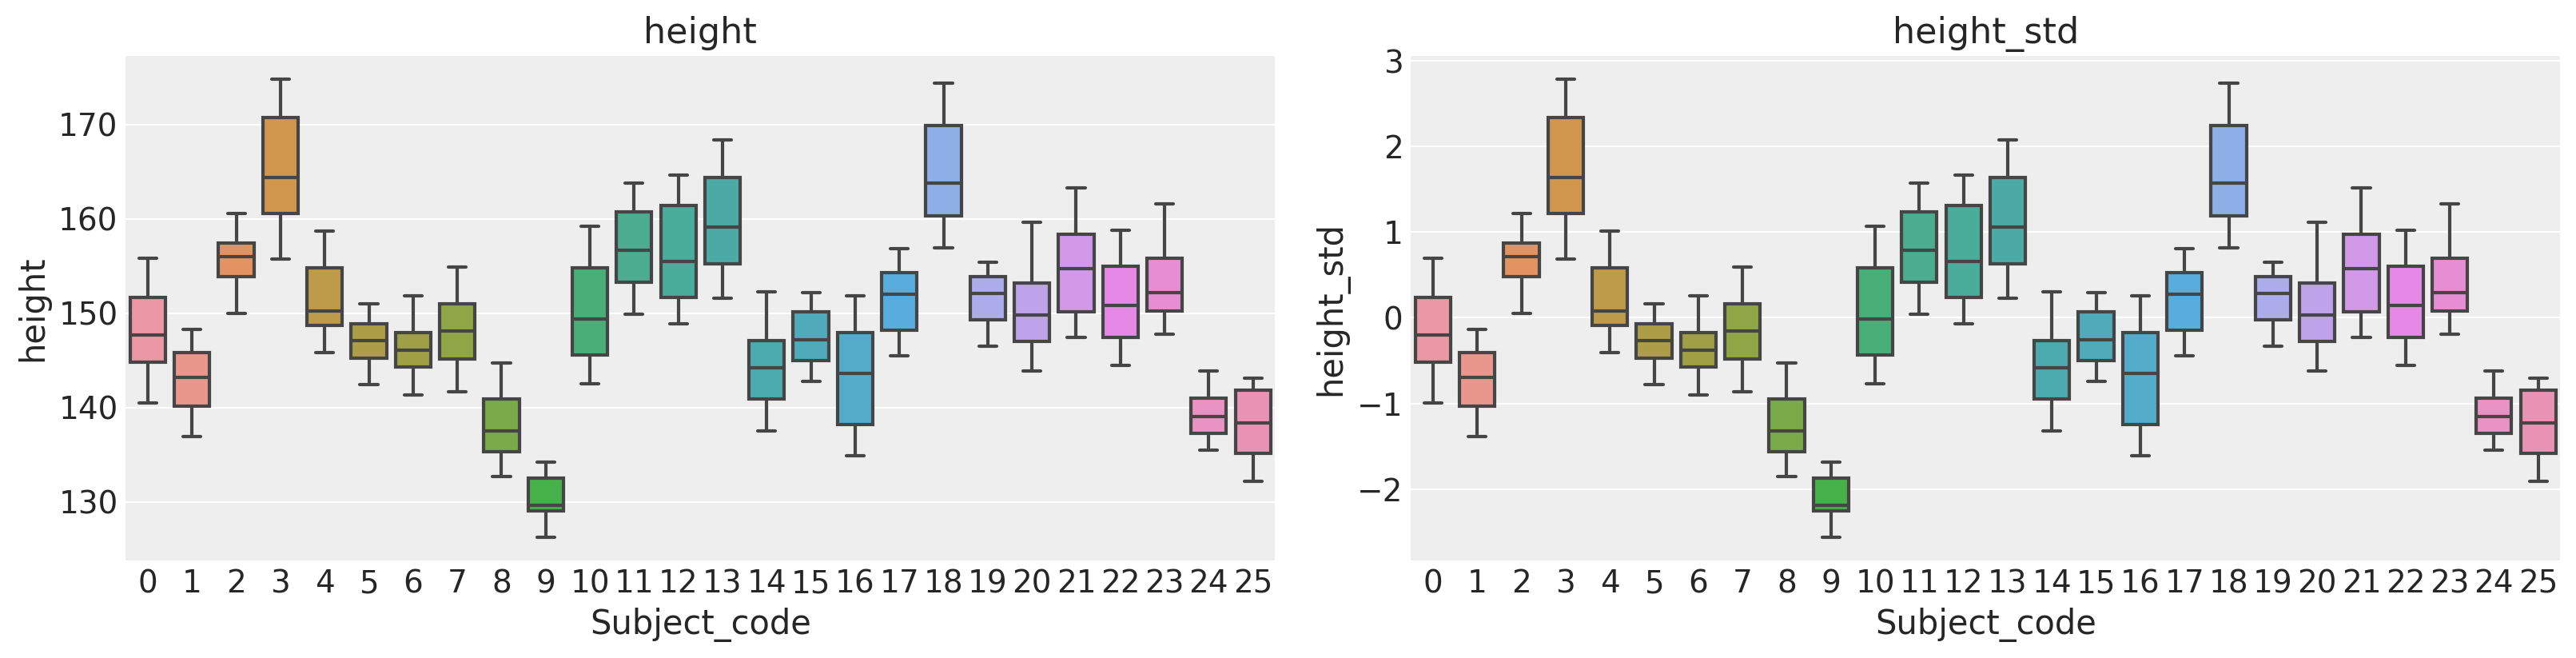

<IPython.core.display.Javascript object>

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.boxplot(data=df_oxboys, x='Subject_code', y='height', ax=ax1)
sns.boxplot(data=df_oxboys, x='Subject_code', y='height_std', ax=ax2)

ax1.set_title('height')
ax2.set_title('height_std')

In [ ]:
with pm.Model() as mq4:

    # Priors
    a = pm.Normal("a", mu=0, sd=1, shape=n_subjects)
    b = pm.Lognormal("b", mu=0, sd=1, shape=n_subjects)
    sigma = pm.Exponential("sigma", 1)

    # linear model (mu is deterministic)
    mu = a[df_oxboys['Subject_code']] + b[df_oxboys['Subject_code']] * (df_oxboys['Occasion0'])

    # likelihood
    h = pm.Normal("h", mu=mu, sd=sigma, observed=df_oxboys['height_std'])

    idata_mq4 = pm.sample(1000, tune=1000, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


<IPython.core.display.Javascript object>

In [ ]:
with mq4:
    prior_pred4 = pm.sample_prior_predictive(samples=200, var_names=['a', 'b', 'h'])

<IPython.core.display.Javascript object>

In [ ]:
prior_pred4['a'][0].min(), prior_pred4['b'][0].min(), prior_pred4['b'][0].max()

(-1.7904803679963661, 0.23958642394041826, 6.855408396118241)

<IPython.core.display.Javascript object>

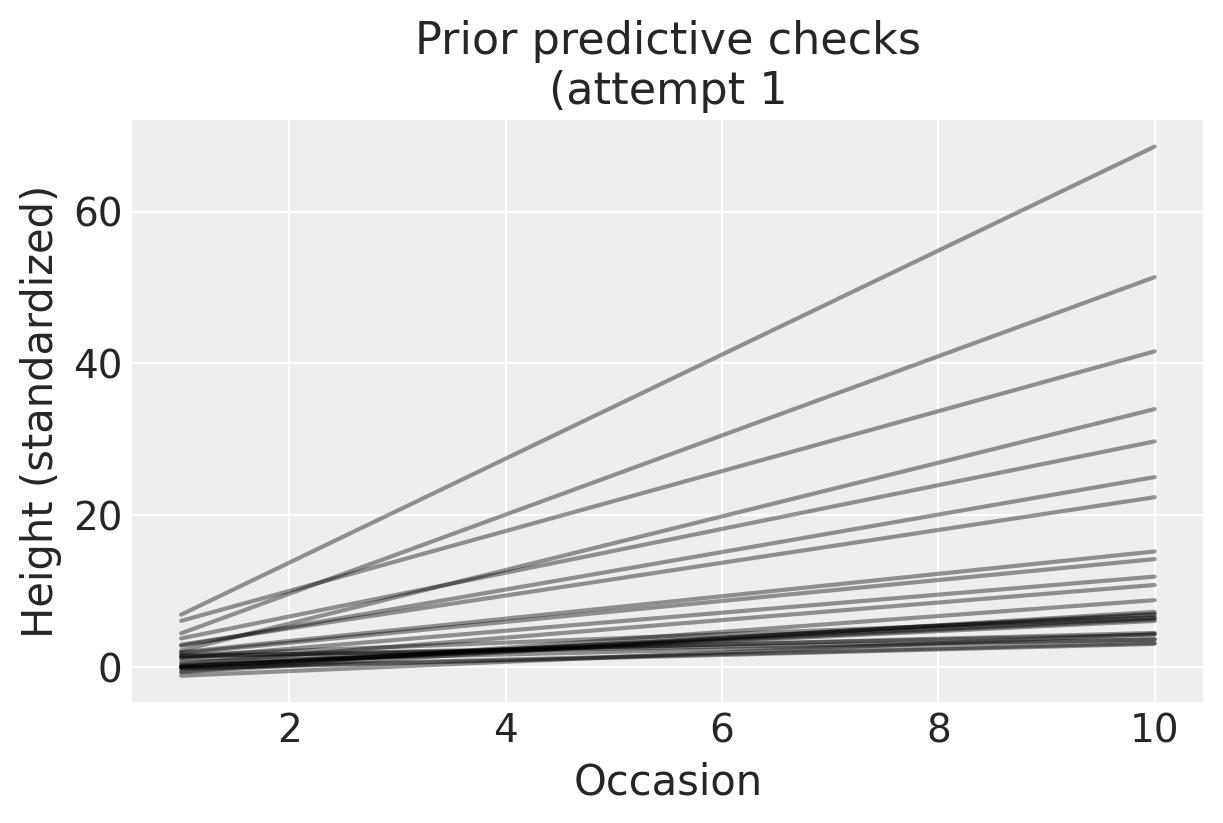

<IPython.core.display.Javascript object>

In [ ]:
f, ax1 = plt.subplots(figsize=(6, 4))

x = np.linspace(1, 10)
for a, b in zip(prior_pred4["a"][0], prior_pred4["b"][0]):
    y = a + b * x
    ax1.plot(x, y, c="k", alpha=0.4)

ax1.set_xlabel("Occasion")
ax1.set_ylabel("Height (standardized)")
ax1.set_title("Prior predictive checks\n(attempt 1");

This is too implausible. I'm going to constrain beta. I tested different values but am just showing the final result.

In [ ]:
with pm.Model() as mq4b:

    # Priors
    a = pm.Normal("a", mu=0, sd=1, shape=n_subjects)
    b = pm.Lognormal("b", mu=0, sd=0.1, shape=n_subjects)
    sigma = pm.Exponential("sigma", 1)

    # linear model (mu is deterministic)
    mu = a[df_oxboys['Subject_code']] + b[df_oxboys['Subject_code']] * (df_oxboys['Occasion0'])

    # likelihood
    h = pm.Normal("h", mu=mu, sd=sigma, observed=df_oxboys['height_std'])

    # prior predictive
    prior_pred4b = pm.sample_prior_predictive(samples=200, var_names=['a', 'b', 'h'])

    idata_mq4b = pm.sample(1000, tune=1000, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


<IPython.core.display.Javascript object>

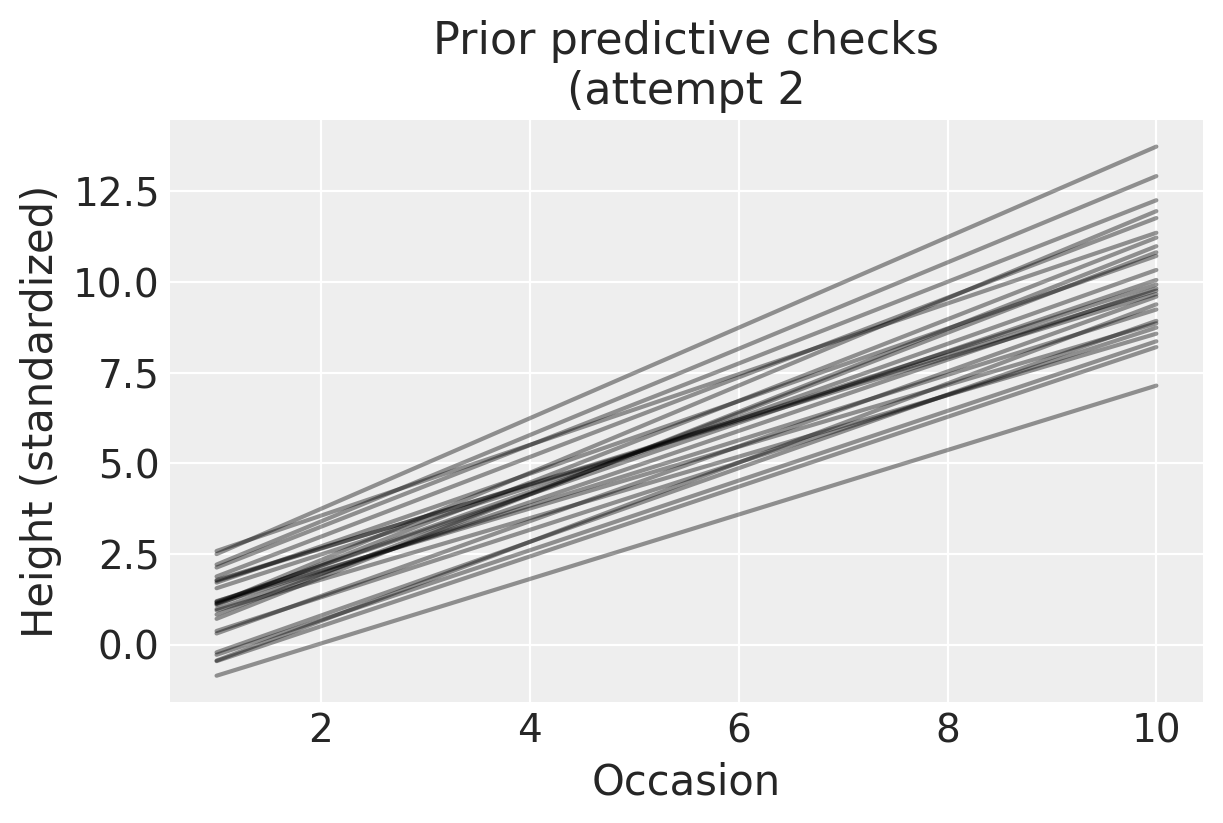

<IPython.core.display.Javascript object>

In [ ]:
f, ax1 = plt.subplots(figsize=(6, 4))

x = np.linspace(1, 10)
for a, b in zip(prior_pred4b["a"][0], prior_pred4b["b"][0]):
    y = a + b * x
    ax1.plot(x, y, c="k", alpha=0.4)

ax1.set_xlabel("Occasion")
ax1.set_ylabel("Height (standardized)")
ax1.set_title("Prior predictive checks\n(attempt 2");

Something doesn't make sense to me. Maybe I need to standardize within each boy?

In [ ]:
std_win_boy = list()
for i in range(n_subjects):
    std_win_boy += standardize(df_oxboys.loc[df_oxboys['Subject_code']==i, 'height']).tolist()

df_oxboys['height_stdwin'] = std_win_boy

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='Subject_code', ylabel='height_stdwin'>

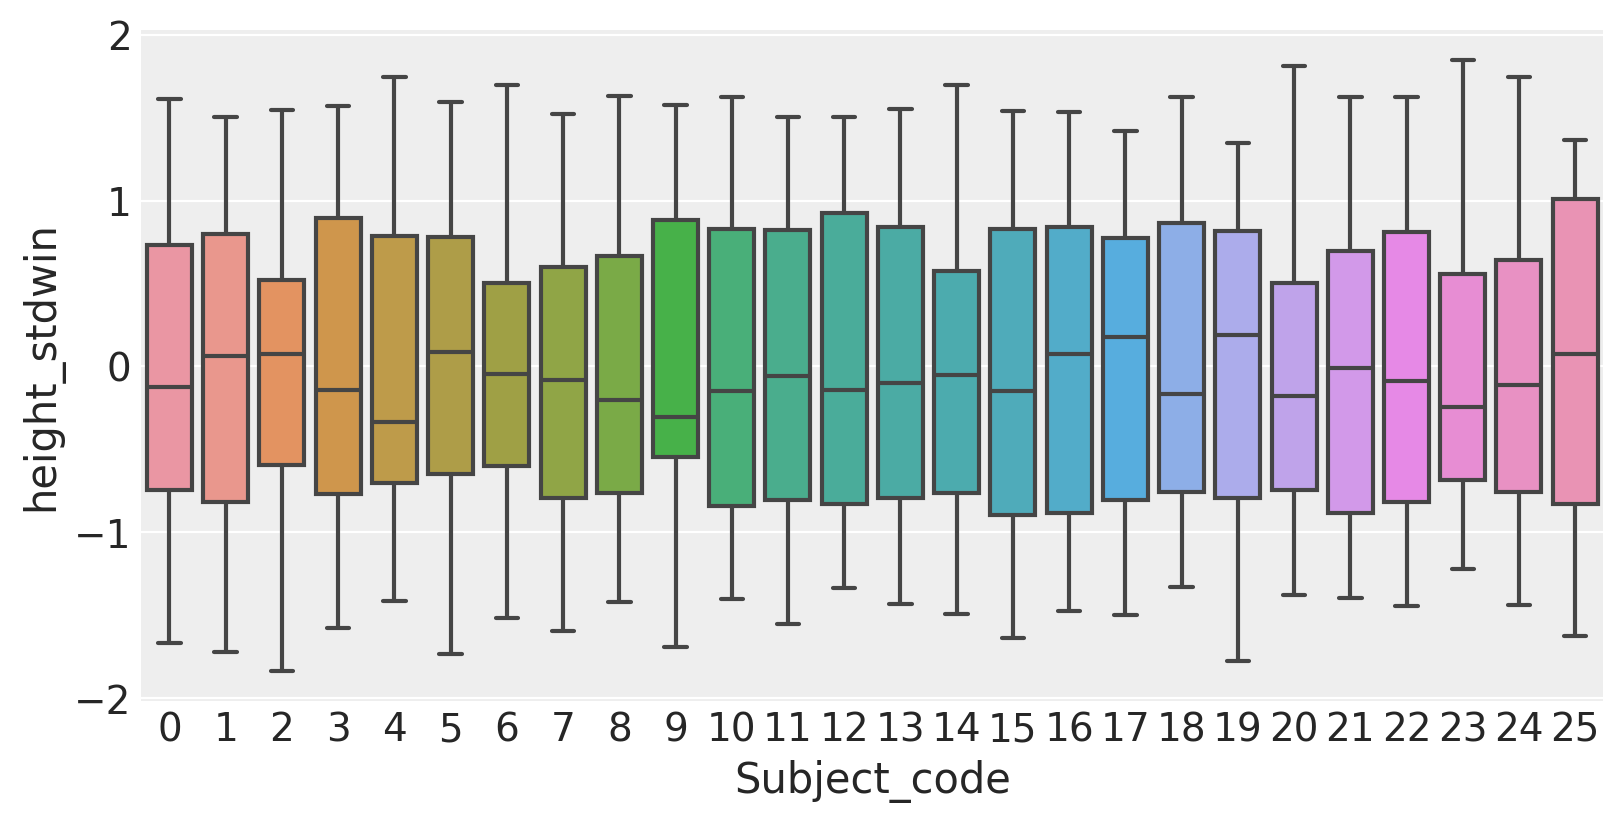

<IPython.core.display.Javascript object>

In [ ]:
f, ax1 = plt.subplots(1, 1, figsize=(8, 4))
sns.boxplot(data=df_oxboys, x='Subject_code', y='height_stdwin', ax=ax1)

Tigher SD on beta?

In [ ]:
with pm.Model() as mq4c:

    # Priors
    a = pm.Normal("a", mu=0, sd=1, shape=n_subjects)
    b = pm.Lognormal("b", mu=0, sd=0.01, shape=n_subjects)
    sigma = pm.Exponential("sigma", 1)

    # linear model (mu is deterministic)
    mu = a[df_oxboys['Subject_code']] + b[df_oxboys['Subject_code']] * (df_oxboys['Occasion0'])

    # likelihood
    h = pm.Normal("h", mu=mu, sd=sigma, observed=df_oxboys['height_stdwin'])

    # prior predictive
    prior_pred4c = pm.sample_prior_predictive(samples=200, var_names=['a', 'b', 'h'])

    idata_mq4c = pm.sample(1000, tune=1000, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


<IPython.core.display.Javascript object>

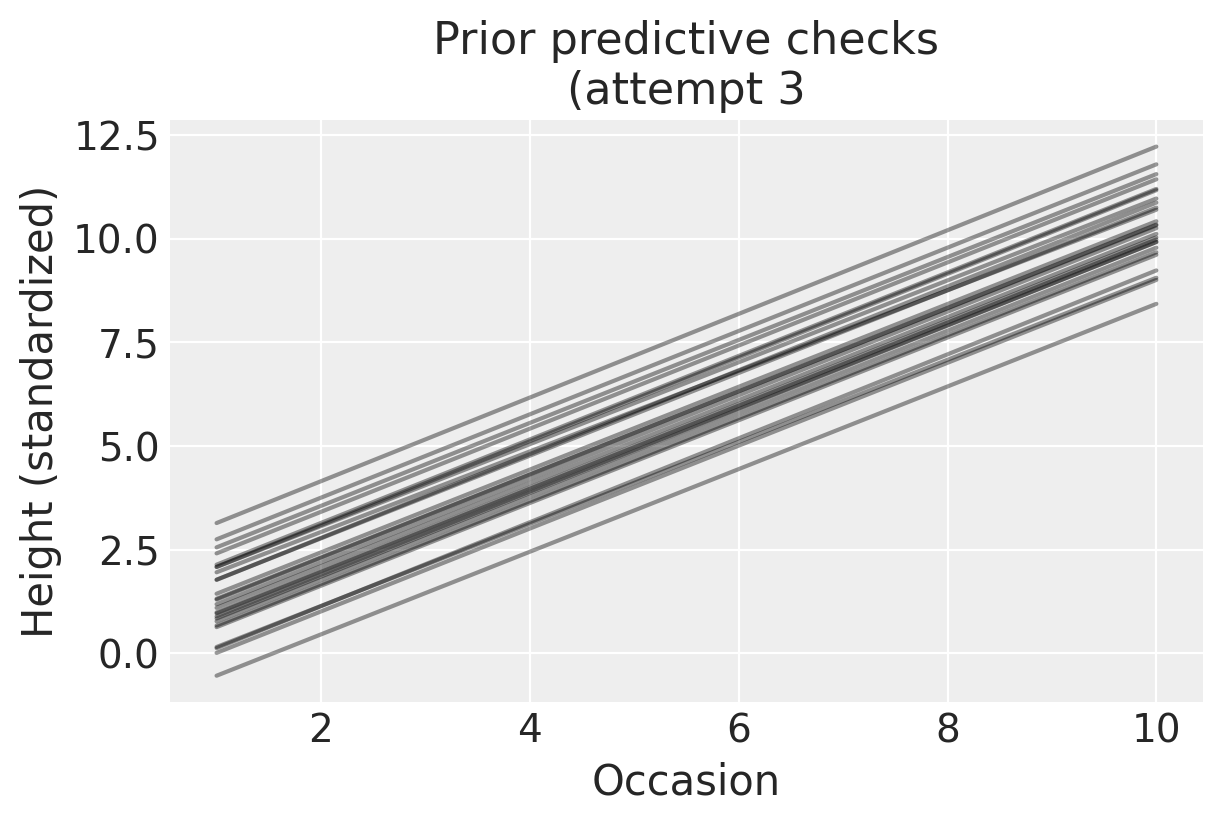

<IPython.core.display.Javascript object>

In [ ]:
f, ax1 = plt.subplots(figsize=(6, 4))

x = np.linspace(1, 10)
for a, b in zip(prior_pred4c["a"][0], prior_pred4c["b"][0]):
    y = a + b * x
    ax1.plot(x, y, c="k", alpha=0.4)

ax1.set_xlabel("Occasion")
ax1.set_ylabel("Height (standardized)")
ax1.set_title("Prior predictive checks\n(attempt 3");

Not sure if this is the right approach.

Appendix: Environment and system parameters

In [ ]:
%watermark -n -u -v -iv -w

Last updated: Thu Jan 13 2022

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

sys       : 3.8.6 | packaged by conda-forge | (default, Jan 25 2021, 23:22:12) 
[Clang 11.0.1 ]
pymc3     : 3.11.0
arviz     : 0.11.1
numpy     : 1.20.1
pandas    : 1.2.1
seaborn   : 0.11.1
scipy     : 1.6.0
matplotlib: 3.3.4
daft      : 0.1.0

Watermark: 2.1.0



<IPython.core.display.Javascript object>